In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("priyaadharshinivs062/leukemia-dataset-02")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/leukemia-dataset-02


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.models import vit_b_16
from torchvision.transforms.functional import normalize
import torchvision.datasets as datasets
import torchvision.models as models
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import os
import cv2

In [3]:
# Dataset Paths
dataset_base_path = "/kaggle/input/leukemia-dataset-02/archive (1)"
train_dir = os.path.join(dataset_base_path, "train")
test_dir = os.path.join(dataset_base_path, "test")

print("Training Directory:", train_dir)
print("Testing Directory:", test_dir)

# Verify class folders inside the train directory
print("Classes in training directory:", os.listdir(train_dir))


Training Directory: /kaggle/input/leukemia-dataset-02/archive (1)/train
Testing Directory: /kaggle/input/leukemia-dataset-02/archive (1)/test
Classes in training directory: ['CML', 'H', 'ALL', 'AML', 'CLL']


In [4]:
# Class mapping
class_map = {'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'H': 4}
classes = list(class_map.keys())

# Function to collect image paths and labels
def collect_data(data_dir):
    image_paths = []
    labels = []
    for class_name, class_label in class_map.items():
        class_folder = os.path.join(data_dir, class_name)
        if os.path.exists(class_folder):
            for file in os.listdir(class_folder):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_folder, file))
                    labels.append(class_label)
        else:
            print(f"Directory {class_folder} not found")
    return image_paths, labels

Displaying images from: /kaggle/input/leukemia-dataset-02/archive (1)/train


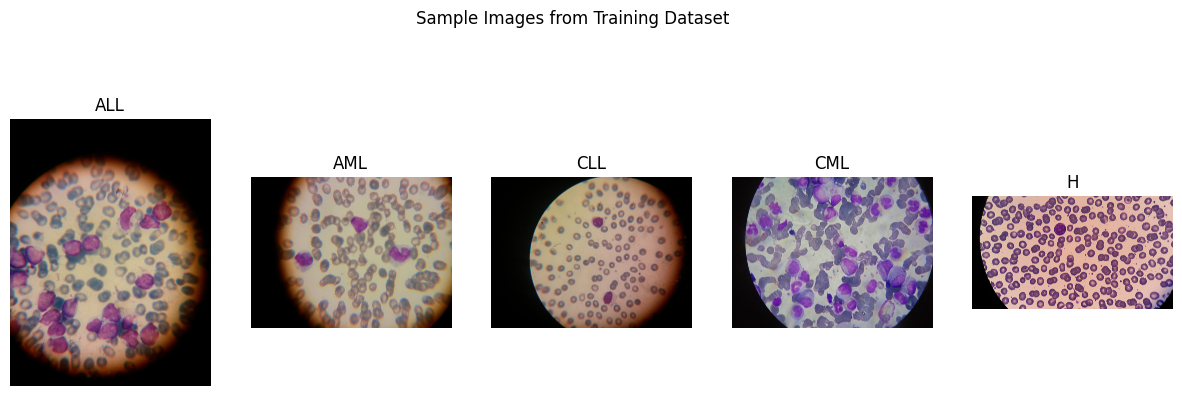

Total training images: 15000
Total testing images: 5000


In [5]:
# Function to count total images in a directory
def count_total_images(directory):
    total_images = 0
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        # Count all image files in the folder
        total_images += len([img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
    return total_images

# Function to display one image per class
def show_images_from_each_class(directory, title):
    print(f"Displaying images from: {directory}")
    plt.figure(figsize=(15, 5))  # Set the plot size
    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        # List all image files in the folder
        image_files = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if image_files:
            image_path = os.path.join(class_path, image_files[0])
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
            plt.subplot(1, len(classes), i + 1)  # Create a subplot for each class
            plt.imshow(image)
            plt.title(class_name)
            plt.axis("off")  # Remove axis for better visualization
    plt.suptitle(title)
    plt.show()

# Show one image per class
show_images_from_each_class(train_dir, "Sample Images from Training Dataset")

# Count total images in train and test directories
total_train_images = count_total_images(train_dir)
total_test_images = count_total_images(test_dir)

# Print the total number of images
print(f"Total training images: {total_train_images}")
print(f"Total testing images: {total_test_images}")


In [6]:
# Define the transformations for training, validation, and testing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Resize and crop to 224x224
    transforms.RandomRotation(5),  # Random rotation between -10 and 10 degrees
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.1, hue=0.02),  # Color jitter
    transforms.ToTensor(),  # Convert the image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

val_transform = transforms.Compose([
    transforms.Resize(256),  # Resize to 256px on the shorter side
    transforms.CenterCrop(224),  # Crop the center of the image to 224x224
    transforms.ToTensor(),  # Convert the image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

test_transform = transforms.Compose([
    transforms.Resize(256),  # Resize to 256px on the shorter side
    transforms.CenterCrop(224),  # Crop the center of the image to 224x224
    transforms.ToTensor(),  # Convert the image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

# Define the full dataset for training
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform
)

# Calculate the size for the validation set (10% of the total dataset)
val_size = int(0.1 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size

# Split the dataset into training and validation
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Define test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Create DataLoader for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Choose an appropriate batch size
 
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False) # Choose an appropriate batch size

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # Choose an appropriate batch size

# Print the number of images in each dataset
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")


Number of training images: 13500
Number of validation images: 1500
Number of test images: 5000


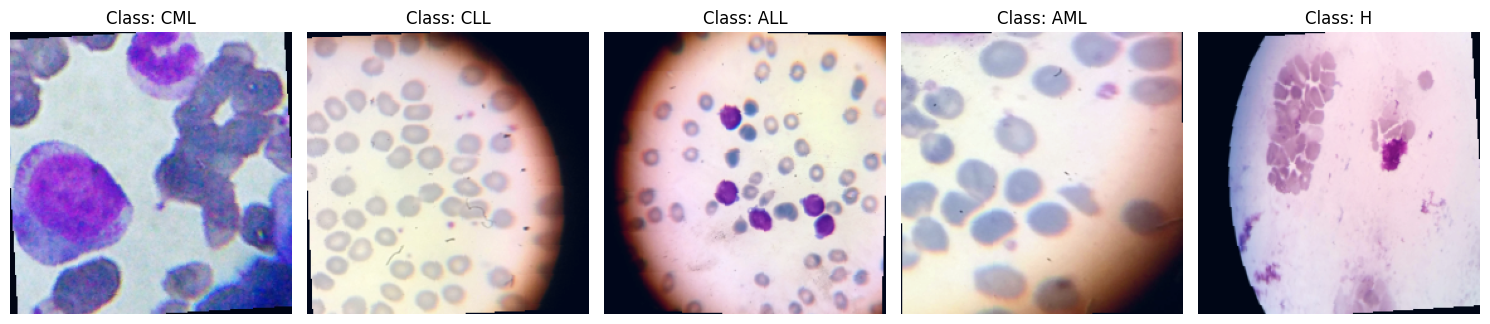

In [9]:
# Function to visualize one image from each class after augmentation
def show_one_image_from_each_class(dataloader, classes, num_classes=5):
    """
    Visualize one augmented image from each class.
    
    Args:
        dataloader (DataLoader): The PyTorch DataLoader.
        classes (list): List of class names.
        num_classes (int): Number of classes to visualize.
    """
    # Initialize a figure with subplots for each class
    plt.figure(figsize=(15, 5))
    
    # Track which classes have been visualized
    visualized_classes = set()
    
    # Iterate through the DataLoader until we get one image from each class
    for images, labels in dataloader:
        # Loop through the batch
        for img, label in zip(images, labels):
            class_idx = label.item()
            if class_idx not in visualized_classes:
                # Add to visualized classes
                visualized_classes.add(class_idx)
                
                # Convert image tensor to numpy format (C x H x W -> H x W x C)
                img = img.permute(1, 2, 0).numpy()  # Rearrange dimensions for matplotlib (HWC)
                
                # Normalize for display to ensure the image is shown correctly
                img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
                
                # Plot the image
                plt.subplot(1, num_classes, len(visualized_classes))  # Create a subplot for each class
                plt.imshow(img)
                plt.title(f"Class: {classes[class_idx]}")
                plt.axis('off')  # Remove axis for better visualization
                
                # Break if we have visualized all classes
                if len(visualized_classes) == num_classes:
                    break
        
        # Break outer loop if we have visualized all classes
        if len(visualized_classes) == num_classes:
            break
    
    # Display the image grid
    plt.tight_layout()
    plt.show()

# Example usage
classes = full_train_dataset.classes  # List of class names
show_one_image_from_each_class(train_loader, classes)


In [10]:
import timm

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the ViT model (ViT-B/16) using timm with pretrained weights
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Move the model to the device
model = model.to(device)

# Freeze the base model parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the classifier head
num_ftrs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, len(train_dataset.dataset.classes))  # Replace with your dataset's number of classes
)

# Move the modified model to the same device
model = model.to(device)

# Summarize the model using torchinfo
summary(model, input_size=(1, 3, 224, 224), device=device.type)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
VisionTransformer                        [1, 5]                    152,064
├─PatchEmbed: 1-1                        [1, 196, 768]             --
│    └─Conv2d: 2-1                       [1, 768, 14, 14]          (590,592)
│    └─Identity: 2-2                     [1, 196, 768]             --
├─Dropout: 1-2                           [1, 197, 768]             --
├─Identity: 1-3                          [1, 197, 768]             --
├─Identity: 1-4                          [1, 197, 768]             --
├─Sequential: 1-5                        [1, 197, 768]             --
│    └─Block: 2-3                        [1, 197, 768]             --
│    │    └─LayerNorm: 3-1               [1, 197, 768]             (1,536)
│    │    └─Attention: 3-2               [1, 197, 768]             (2,362,368)
│    │    └─Identity: 3-3                [1, 197, 768]             --
│    │    └─Identity: 3-4                [1, 197, 768]     

In [11]:
# Print the model summary
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [12]:
from sklearn.metrics import precision_score, recall_score

def train_model(model, criterion, optimizer, train_loader, val_loader=None, epochs=20, scheduler=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    train_precisions = []
    train_recalls = []
    val_precisions = []
    val_recalls = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_train_preds = []
        all_train_labels = []

        # Training loop
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch") as pbar:
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                # Calculate accuracy for the current batch
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_train_preds.extend(predicted.cpu().numpy())
                all_train_labels.extend(labels.cpu().numpy())
                batch_accuracy = correct / total  # Decimal format accuracy

                # Update the progress bar with current loss and accuracy
                pbar.set_postfix(loss=running_loss / (pbar.n + 1), accuracy=batch_accuracy)

        # Track the losses and accuracies after training
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)  # Store as a decimal

        # Calculate Precision and Recall for the training set
        precision = precision_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        recall = recall_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_precisions.append(precision)
        train_recalls.append(recall)

        # Validation loop (only if val_loader is provided)
        if val_loader:
            model.eval()  # Set the model to evaluation mode
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            all_val_preds = []
            all_val_labels = []

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    # Calculate accuracy for the current batch
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    all_val_preds.extend(predicted.cpu().numpy())
                    all_val_labels.extend(labels.cpu().numpy())

            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_correct / val_total)  # Store as a decimal

            # Calculate Precision and Recall for the validation set
            val_precision = precision_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)
            val_recall = recall_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)
            val_precisions.append(val_precision)
            val_recalls.append(val_recall)

        # Print epoch results
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
        if val_loader:
            print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}")

        # Step the scheduler at the end of the epoch
        if scheduler:
            scheduler.step()
            print(f"Learning rate after epoch {epoch+1}: {scheduler.get_last_lr()}")

    return train_losses, train_accuracies, val_losses, val_accuracies, train_precisions, train_recalls, val_precisions, val_recalls

# Define the criterion, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [ ]:
# Train the model
train_losses, train_accuracies, val_losses, val_accuracies, train_precisions, train_recalls, val_precisions, val_recalls = train_model(
    model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler)

Epoch 1/20: 100%|██████████| 422/422 [41:27<00:00,  5.89s/batch, accuracy=0.705, loss=0.785]


Epoch 1/20
Train Loss: 0.7849, Train Accuracy: 0.7050
Validation Loss: 0.4966, Validation Accuracy: 0.8233
Learning rate after epoch 1: [0.0001]


Epoch 2/20: 100%|██████████| 422/422 [35:00<00:00,  4.98s/batch, accuracy=0.823, loss=0.469]


Epoch 2/20
Train Loss: 0.4695, Train Accuracy: 0.8227
Validation Loss: 0.3757, Validation Accuracy: 0.8660
Learning rate after epoch 2: [0.0001]


Epoch 3/20: 100%|██████████| 422/422 [34:42<00:00,  4.94s/batch, accuracy=0.857, loss=0.387]


Epoch 3/20
Train Loss: 0.3873, Train Accuracy: 0.8575
Validation Loss: 0.3201, Validation Accuracy: 0.8907
Learning rate after epoch 3: [0.0001]


Epoch 4/20: 100%|██████████| 422/422 [34:37<00:00,  4.92s/batch, accuracy=0.874, loss=0.342]


Epoch 4/20
Train Loss: 0.3419, Train Accuracy: 0.8741
Validation Loss: 0.3126, Validation Accuracy: 0.8887
Learning rate after epoch 4: [0.0001]


Epoch 5/20: 100%|██████████| 422/422 [34:54<00:00,  4.96s/batch, accuracy=0.892, loss=0.303]


Epoch 5/20
Train Loss: 0.3035, Train Accuracy: 0.8916
Validation Loss: 0.2623, Validation Accuracy: 0.9067
Learning rate after epoch 5: [5e-05]


Epoch 6/20: 100%|██████████| 422/422 [34:27<00:00,  4.90s/batch, accuracy=0.9, loss=0.279]  


Epoch 6/20
Train Loss: 0.2789, Train Accuracy: 0.9003
Validation Loss: 0.2431, Validation Accuracy: 0.9193
Learning rate after epoch 6: [5e-05]


Epoch 7/20: 100%|██████████| 422/422 [34:27<00:00,  4.90s/batch, accuracy=0.905, loss=0.269]


Epoch 7/20
Train Loss: 0.2690, Train Accuracy: 0.9053
Validation Loss: 0.2293, Validation Accuracy: 0.9233
Learning rate after epoch 7: [5e-05]


Epoch 8/20: 100%|██████████| 422/422 [34:44<00:00,  4.94s/batch, accuracy=0.913, loss=0.251]


Epoch 8/20
Train Loss: 0.2509, Train Accuracy: 0.9125
Validation Loss: 0.2221, Validation Accuracy: 0.9200
Learning rate after epoch 8: [5e-05]


Epoch 9/20: 100%|██████████| 422/422 [34:49<00:00,  4.95s/batch, accuracy=0.915, loss=0.245]


Epoch 9/20
Train Loss: 0.2449, Train Accuracy: 0.9151
Validation Loss: 0.2364, Validation Accuracy: 0.9173
Learning rate after epoch 9: [5e-05]


Epoch 10/20: 100%|██████████| 422/422 [34:35<00:00,  4.92s/batch, accuracy=0.916, loss=0.238]


Epoch 10/20
Train Loss: 0.2378, Train Accuracy: 0.9160
Validation Loss: 0.2177, Validation Accuracy: 0.9200
Learning rate after epoch 10: [2.5e-05]


Epoch 11/20: 100%|██████████| 422/422 [34:38<00:00,  4.93s/batch, accuracy=0.922, loss=0.227]


Epoch 11/20
Train Loss: 0.2265, Train Accuracy: 0.9224
Validation Loss: 0.2152, Validation Accuracy: 0.9340
Learning rate after epoch 11: [2.5e-05]


Epoch 12/20: 100%|██████████| 422/422 [30:09<00:00,  4.29s/batch, accuracy=0.918, loss=0.232]


Epoch 12/20
Train Loss: 0.2323, Train Accuracy: 0.9179
Validation Loss: 0.1978, Validation Accuracy: 0.9300
Learning rate after epoch 12: [2.5e-05]


Epoch 13/20: 100%|██████████| 422/422 [28:38<00:00,  4.07s/batch, accuracy=0.924, loss=0.218]


Epoch 13/20
Train Loss: 0.2185, Train Accuracy: 0.9236
Validation Loss: 0.2176, Validation Accuracy: 0.9167
Learning rate after epoch 13: [2.5e-05]


Epoch 14/20:  95%|█████████▍| 399/422 [26:36<01:37,  4.22s/batch, accuracy=0.925, loss=0.216]

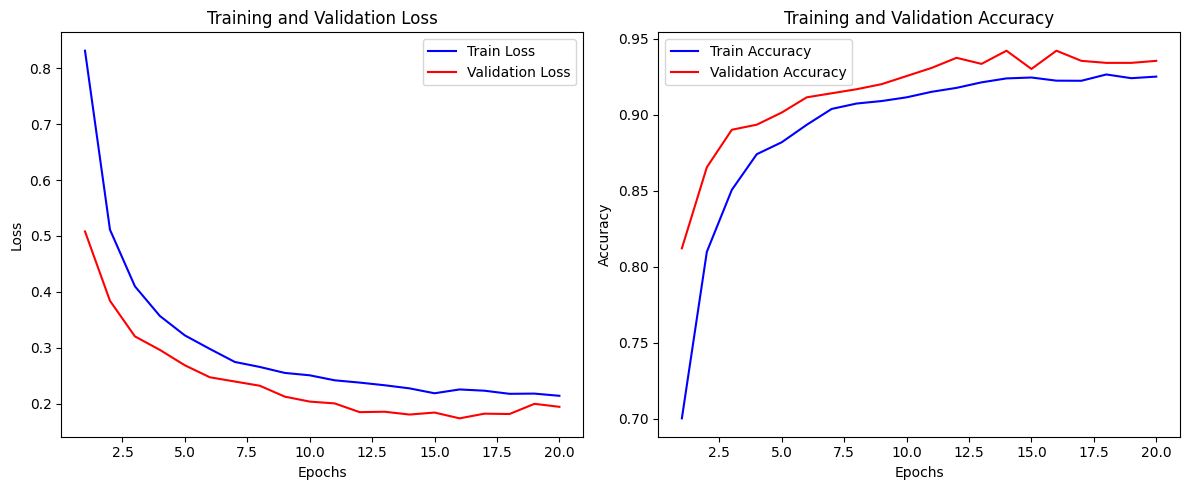

In [11]:
def plot_training_curves(train_losses, train_accuracies, val_losses=None, val_accuracies=None,
                         train_precisions=None, train_recalls=None, val_precisions=None, val_recalls=None):
    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation losses
    plt.figure(figsize=(12, 10))

    # Loss plot
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", color='blue')
    if val_losses:
        plt.plot(epochs, val_losses, label="Validation Loss", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy", color='blue')
    if val_accuracies:
        plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Precision plot
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_precisions, label="Train Precision", color='blue')
    if val_precisions:
        plt.plot(epochs, val_precisions, label="Validation Precision", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.title('Training and Validation Precision')
    plt.legend()

    # Recall plot
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_recalls, label="Train Recall", color='blue')
    if val_recalls:
        plt.plot(epochs, val_recalls, label="Validation Recall", color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training curves
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies,
                     train_precisions, train_recalls, val_precisions, val_recalls)


In [12]:
# Save the full model
torch.save(base_model, 'vit_b_16_leukemia.pth')


In [13]:
import shutil

# Zip the model file
shutil.make_archive('vit_b_16_leukemia', 'zip', '.', 'vit_b_16_leukemia.pth')

'/kaggle/working/vit_b_16.zip'

In [12]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the model
model_path = "/kaggle/input/vit-b-16-leukemia/vit_b_16.pth"
base_model = torch.load(model_path)

Calculating Probabilities: 100%|██████████| 157/157 [16:14<00:00,  6.21s/batch]


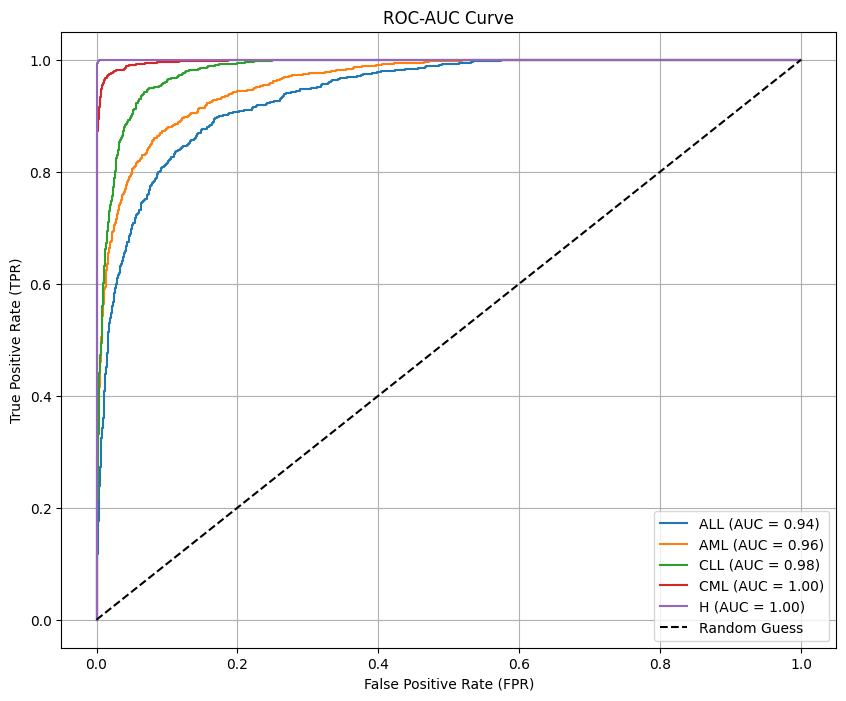

In [10]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# Function to plot ROC-AUC curve
def plot_roc_auc_curve(model, dataloader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)
    
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calculating Probabilities", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)

            # Get model predictions (probabilities)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)

            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convert to numpy arrays
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)

    # Binarize the labels for multi-class ROC-AUC
    y_true_binarized = label_binarize(all_labels, classes=range(len(class_names)))

    # Initialize a plot
    plt.figure(figsize=(10, 8))

    # Compute ROC curve and AUC for each class
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        
        # Plot each class's ROC curve
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

    # Plot diagonal line (random guess)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")

    # Add labels and legend
    plt.title("ROC-AUC Curve")
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Example usage
plot_roc_auc_curve(base_model, test_loader, classes)


In [15]:
def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    test_loss = 0.0
    correct = 0
    total = 0

    with tqdm(test_loader, desc="Evaluating", unit="batch") as pbar:
        with torch.no_grad():
            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                # Use the passed criterion
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # Get predictions
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Accuracy calculation
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                batch_accuracy = correct / total

                # Update progress bar
                pbar.set_postfix(loss=test_loss / (pbar.n + 1), accuracy=batch_accuracy)

    # Final test metrics
    overall_accuracy = correct / total
    print(f"\nTest Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {overall_accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    return all_preds, all_labels


In [16]:
all_preds, all_labels = evaluate_model(base_model, test_loader, criterion)


Evaluating: 100%|██████████| 157/157 [15:29<00:00,  5.92s/batch, accuracy=0.868, loss=0.361]


Test Loss: 0.3615, Test Accuracy: 0.8678

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.72      1000
           1       0.78      0.81      0.79      1000
           2       0.82      0.90      0.86      1000
           3       0.95      0.97      0.96      1000
           4       1.00      0.99      1.00      1000

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



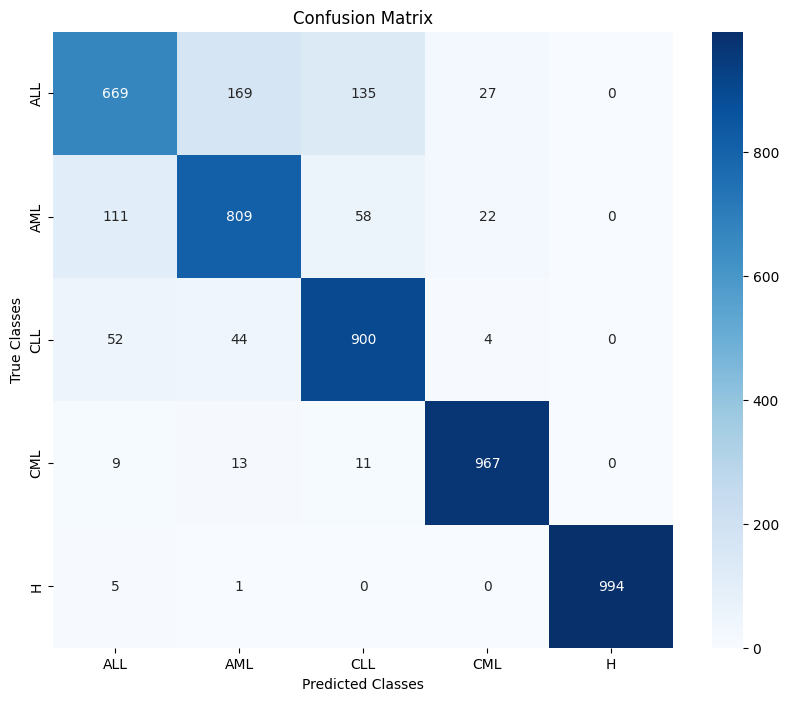

In [17]:
# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Visualize it
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()


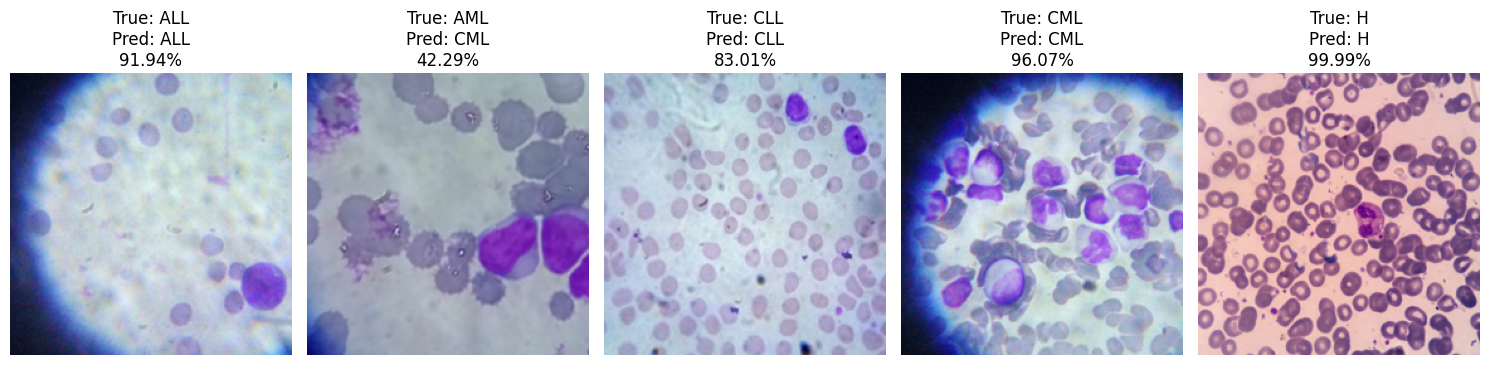

In [18]:
def visualize_predictions(model, dataloader, class_names):
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Track classes visualized
    visualized_classes = set()

    plt.figure(figsize=(15, 5))  # Set the figure size

    # Loop through the DataLoader
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)  # Get prediction probabilities
            _, preds = torch.max(outputs, 1)

            # Loop through the batch
            for img, label, pred, prob in zip(images, labels, preds, probabilities):
                class_idx = label.item()
                if class_idx not in visualized_classes:
                    # Add the class to the visualized set
                    visualized_classes.add(class_idx)

                    # Convert image tensor to numpy for visualization
                    img = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format
                    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

                    # Get the prediction probability for the predicted class
                    pred_percentage = prob[pred].item() * 100

                    # Plot the image
                    plt.subplot(1, len(class_names), len(visualized_classes))
                    plt.imshow(img)
                    plt.title(f"True: {class_names[class_idx]}\nPred: {class_names[pred.item()]}\n{pred_percentage:.2f}%")
                    plt.axis("off")

                    # Stop once all classes are visualized
                    if len(visualized_classes) == len(class_names):
                        break
            if len(visualized_classes) == len(class_names):
                break

    plt.tight_layout()
    plt.show()

# Example usage
visualize_predictions(base_model, test_loader, classes)


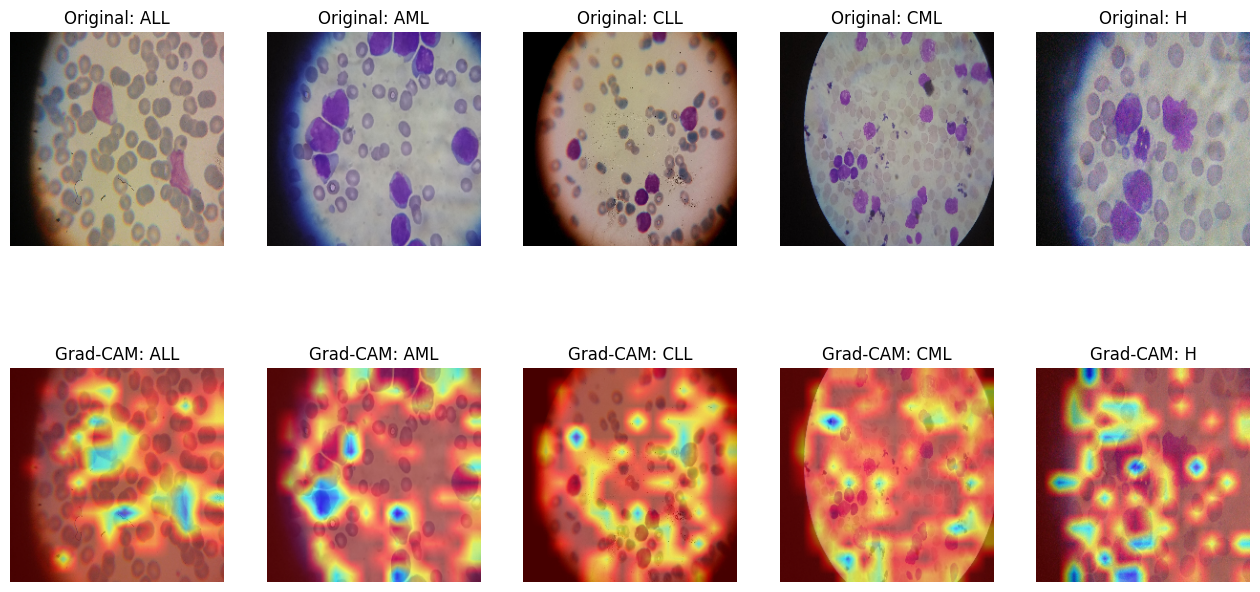

In [31]:
import timm  # PyTorch image models library
from skimage import io  # Image processing from scikit-image


# Class mapping
class_map = {'ALL': 0, 'AML': 1, 'CLL': 2, 'CML': 3, 'H': 4}
classes = list(class_map.keys())

# Function to collect image paths and labels
def collect_data(data_dir):
    image_paths = []
    labels = []
    for class_name, class_label in class_map.items():
        class_folder = os.path.join(data_dir, class_name)
        if os.path.exists(class_folder):
            for file in os.listdir(class_folder):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(class_folder, file))
                    labels.append(class_label)
        else:
            print(f"Directory {class_folder} not found")
    return image_paths, labels

# Grad-CAM class implementation (same as before)
class GradCam:
    def __init__(self, model, target):
        self.model = model.eval()  # Set the model to evaluation mode
        self.feature = None  # To store the features from the target layer
        self.gradient = None  # To store the gradients from the target layer
        self.handlers = []  # List to keep track of hooks
        self.target = target  # Target layer for Grad-CAM
        self._get_hook()  # Register hooks to the target layer

    def _get_features_hook(self, module, input, output):
        self.feature = self.reshape_transform(output)  # Store and reshape the output features

    def _get_grads_hook(self, module, input_grad, output_grad):
        self.gradient = self.reshape_transform(output_grad)  # Store and reshape the output gradients

        def _store_grad(grad):
            self.gradient = self.reshape_transform(grad)  # Store gradients for later use

        output_grad.register_hook(_store_grad)  # Register hook to store gradients

    def _get_hook(self):
        self.target.register_forward_hook(self._get_features_hook)
        self.target.register_forward_hook(self._get_grads_hook)

    def reshape_transform(self, tensor, height=14, width=14):
        result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
        result = result.transpose(2, 3).transpose(1, 2)  # Rearrange dimensions to (C, H, W)
        return result

    def __call__(self, inputs):
        self.model.zero_grad()  # Zero the gradients
        output = self.model(inputs)  # Forward pass

        index = np.argmax(output.cpu().data.numpy())  # Get the index of the highest score
        target = output[0][index]  # Get the target score
        target.backward()  # Backward pass to compute gradients

        # Get the gradients and features
        gradient = self.gradient[0].cpu().data.numpy()
        weight = np.mean(gradient, axis=(1, 2))  # Average the gradients
        feature = self.feature[0].cpu().data.numpy()

        # Compute the weighted sum of the features
        cam = feature * weight[:, np.newaxis, np.newaxis]
        cam = np.sum(cam, axis=0)  # Sum over the channels
        cam = np.maximum(cam, 0)  # Apply ReLU to remove negative values

        # Normalize the heatmap
        cam -= np.min(cam)
        cam /= np.max(cam)
        cam = cv2.resize(cam, (224, 224))  # Resize to match the input image size
        return cam  # Return the Grad-CAM heatmap


# Prepare input function for ViT model
def prepare_input(image):
    image = image.copy()
    # ViT-specific normalization values
    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])
    image -= means
    image /= stds
    image = np.ascontiguousarray(np.transpose(image, (2, 0, 1)))  # (C, H, W)
    image = image[np.newaxis, ...]  # Add batch dimension
    return torch.tensor(image, requires_grad=True)  # Convert to PyTorch tensor

# Function to generate Grad-CAM heatmap
def gen_cam(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = (1 - 0.5) * heatmap + 0.5 * image
    cam = cam / np.max(cam)  # Normalize
    return np.uint8(255 * cam)

# Main execution
if __name__ == '__main__':
    # Define the directory containing the test images
    test_dir = '/kaggle/input/leukemia-dataset-02/archive (1)/test'

    # Collect images and labels
    image_paths, _ = collect_data(test_dir)

    # Create Vision Transformer (ViT) model with pretrained weights
    model = timm.create_model('vit_base_patch16_224', pretrained=True)

    # Select the target layer (last attention block)
    target_layer = model.blocks[-1].norm1  # Targeting the last normalization layer in ViT

    # Initialize Grad-CAM
    grad_cam = GradCam(model, target_layer)

    # Prepare the plot for visualization
    plt.figure(figsize=(16, 8))

    # Loop through one image per class (from image_paths) and apply Grad-CAM
    for i, img_path in enumerate(image_paths[:5]):  # Loop through the first 5 classes
        img = io.imread(img_path)
        img_resized = np.float32(cv2.resize(img, (224, 224))) / 255  # Resize and normalize
        inputs = prepare_input(img_resized)  # Prepare the image for the model

        # Generate the Grad-CAM mask
        mask = grad_cam(inputs)

        # Superimpose Grad-CAM on the original image
        result = gen_cam(img_resized, mask)

        # Display the original image and Grad-CAM result
        plt.subplot(2, 5, i+1)
        plt.imshow(img_resized)
        plt.title(f"Original: {classes[i]}")
        plt.axis('off')

        plt.subplot(2, 5, i+6)
        plt.imshow(result)
        plt.title(f"Grad-CAM: {classes[i]}")
        plt.axis('off')

    # Show the plot
    plt.show()
